Цель проекта: изучить выборку пользователей  

Тариф «Смарт»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [26]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Пропусков нет, колонку с датой надо привести к нужному формату. 

In [27]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Пропусков нет, дату надо привести к нужному формату.

In [28]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Колонку с датами сообщений надо привести к нужному формату.

In [29]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


По информации таблица не требует никаких действий.

In [30]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Колонки с датами надо приветси к нужному формату. Пропуски в churn_date по условию значат, что тариф еще действовал на момент выгрузки. Оставим пока их так.

В данных есть звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

По проекту у нас поставлены следующие задачи для предобработки данных:

    просчитать количество сделанных звонков и израсходованных минут разговора по месяцам;
    просчитать количество отправленных сообщений по месяцам;
    просчитать объем израсходованного интернет-трафика по месяцам;
    узнать помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [31]:
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [32]:
calls['call_date']=pd.to_datetime(calls['call_date'],format='%Y-%m-%d')

После перевода в дату добавим к таблице колонку с месяцем. Также округлим продолжительность звонков в большую сторону, это также прописано в условиях проекта. И изменим тип данных.

In [33]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [34]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int') 

In [35]:
calls.head(5)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


В таблице с данными по использованию интернета колонку с датой переведем в формат даты. Добавим в таблицу колонку с месяцем. Также переведем мегабайты в гигабайты и округлим в большую сторону.

In [36]:
internet['session_date']=pd.to_datetime(internet['session_date'],format='%Y-%m-%d')

In [37]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [38]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9


In [39]:
internet['gb_used'] = (internet['mb_used'] / 1024).apply(np.ceil)

In [40]:
del internet['Unnamed: 0']

In [41]:
internet.head(5)

,id,mb_used,session_date,user_id,month,gb_used
0,1000_0,112.95,2018-11-25,1000,11,1.0
1,1000_1,1052.81,2018-09-07,1000,9,2.0
2,1000_2,1197.26,2018-06-25,1000,6,2.0
3,1000_3,550.27,2018-08-22,1000,8,1.0
4,1000_4,302.56,2018-09-24,1000,9,1.0


В таблицах с информацией о сообщениях и пользователях приведем нужные колонки к формату даты. В таблицу к сообщениям надо добавить колонку с месяцем.

In [42]:
messages['message_date']=pd.to_datetime(messages['message_date'],format='%Y-%m-%d')

In [43]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [44]:
users['churn_date']=pd.to_datetime(users['churn_date'],format='%Y-%m-%d')

In [45]:
users['reg_date']=pd.to_datetime(users['reg_date'],format='%Y-%m-%d')

In [46]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Добавив колонки и изменив типы данных, приступим к сборке общей таблицы. Сгруппируем данные по пользователям помесячно, суммируем звонки и потраченный интернет, подсчитаем количество сообщений. Объеденим таблицы.   

In [47]:
calls = calls.groupby(['user_id', 'month']).agg({'id': 'count', "duration": "sum"}).rename(columns={'id':'total_calls'}).reset_index()
internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
messages = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).rename(columns = {'id': 'messages'}).reset_index()

report = calls.merge(internet, on = ['user_id', 'month'], how = 'outer')\
.merge(messages, on = ['user_id', 'month'], how = 'outer').fillna(0)
report = report.merge(users, on = 'user_id', how = 'left').merge(tariffs, left_on = 'tariff',
right_on = 'tariff_name', how = 'left')
report

,user_id,month,total_calls,duration,mb_used,messages,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,22.0,159.0,2253.49,22.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,43.0,172.0,23233.77,60.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,47.0,340.0,14003.64,75.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,52.0,408.0,14055.93,81.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,58.0,466.0,14568.91,57.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,11050.56,17.0,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3210,1489,9,0.0,0.0,17206.30,32.0,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3211,1489,10,0.0,0.0,19559.44,21.0,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3212,1489,11,0.0,0.0,17491.56,20.0,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,smart


In [48]:
report.isna().sum()

user_id                     0
month                       0
total_calls                 0
duration                    0
mb_used                     0
messages                    0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
tariff_name                 0
dtype: int64

Посчитаем выручку для каждого тарифа, алгоритм уже есть в условиях: "вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану". Добавим в общую таблицу колонку с выручкой.

In [49]:
def get_revenue(row):
    if row['tariff'] == 'smart': # добавляем условие по тарифу 
        minutes_over = (row['duration'] - row['minutes_included']) *  row['rub_per_minute']
        sms_over = (row['messages'] - row['messages_included']) *  row['rub_per_message']
        traffic_over = (row['mb_used'] - row['mb_per_month_included']) *  (row['rub_per_gb'] / 1024) # считаем в гигабайтах 
        if minutes_over < 0:
            minutes_over = 0
        if sms_over < 0:
            sms_over = 0
        if traffic_over < 0:
            traffic_over = 0
        total =  minutes_over + sms_over + traffic_over + 550 # прибавляем базовую стоимость тарифа 
    
    if row['tariff'] == 'ultra':
        minutes_over = (row['duration'] - row['minutes_included']) *  row['rub_per_minute']
        sms_over = (row['messages'] - row['messages_included']) *  row['rub_per_message']
        traffic_over = (row['mb_used'] - row['mb_per_month_included']) *  (row['rub_per_gb'] / 1024)
        if minutes_over < 0:
            minutes_over = 0
        if sms_over < 0:
            sms_over = 0
        if traffic_over < 0:
            traffic_over = 0
        total =  minutes_over + sms_over + traffic_over + 1950
    return total     
report['revenue'] = report.apply(get_revenue, axis = 1)
report['revenue'] = report['revenue'].round(2)
report.head(10)


   

,user_id,month,total_calls,duration,mb_used,messages,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,5,22.0,159.0,2253.49,22.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
1,1000,6,43.0,172.0,23233.77,60.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
2,1000,7,47.0,340.0,14003.64,75.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
3,1000,8,52.0,408.0,14055.93,81.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
4,1000,9,58.0,466.0,14568.91,57.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
5,1000,10,57.0,350.0,14702.49,73.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
6,1000,11,43.0,338.0,14756.47,58.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
7,1000,12,46.0,333.0,9817.61,70.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
8,1001,11,59.0,430.0,18429.34,0.0,41,NaT,Москва,Иван,...,smart,50,15360,500,550,200,3,3,smart,1149.48
9,1001,12,63.0,414.0,14036.66,0.0,41,NaT,Москва,Иван,...,smart,50,15360,500,550,200,3,3,smart,550.00


Приступим к анализу данных. 
Поставленная задача: 
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Из общей таблицы создаем две, рассортировав данные согласно тарифу. 

In [50]:
ultra = report[(report['tariff'] == 'ultra')]
ultra

,user_id,month,total_calls,duration,mb_used,messages,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,5,22.0,159.0,2253.49,22.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
1,1000,6,43.0,172.0,23233.77,60.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
2,1000,7,47.0,340.0,14003.64,75.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
3,1000,8,52.0,408.0,14055.93,81.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
4,1000,9,58.0,466.0,14568.91,57.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,1473,9,0.0,0.0,17289.85,19.0,18,NaT,Красноярск,Николай,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
3205,1473,10,0.0,0.0,13688.65,20.0,18,NaT,Красноярск,Николай,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
3206,1473,11,0.0,0.0,21673.80,14.0,18,NaT,Красноярск,Николай,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
3207,1473,12,0.0,0.0,18418.26,20.0,18,NaT,Красноярск,Николай,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0


In [51]:
smart = report[(report['tariff'] == 'smart')]
smart

,user_id,month,total_calls,duration,mb_used,messages,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
8,1001,11,59.0,430.0,18429.34,0.0,41,NaT,Москва,Иван,...,smart,50,15360,500,550,200,3,3,smart,1149.48
9,1001,12,63.0,414.0,14036.66,0.0,41,NaT,Москва,Иван,...,smart,50,15360,500,550,200,3,3,smart,550.00
10,1002,6,15.0,117.0,10856.82,4.0,59,NaT,Стерлитамак,Евгений,...,smart,50,15360,500,550,200,3,3,smart,550.00
11,1002,7,26.0,214.0,17580.10,11.0,59,NaT,Стерлитамак,Евгений,...,smart,50,15360,500,550,200,3,3,smart,983.61
12,1002,8,42.0,289.0,20319.26,13.0,59,NaT,Стерлитамак,Евгений,...,smart,50,15360,500,550,200,3,3,smart,1518.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,11050.56,17.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,smart,550.00
3210,1489,9,0.0,0.0,17206.30,32.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,smart,910.61
3211,1489,10,0.0,0.0,19559.44,21.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,smart,1370.20
3212,1489,11,0.0,0.0,17491.56,20.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,smart,966.32


In [52]:
smart_stat = smart[['duration', 'messages', 'mb_used']]
smart_stat.describe()


,duration,messages,mb_used
count,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16208.386990
std,190.313730,28.227876,5870.476681
min,0.000000,0.000000,0.000000
25%,282.000000,10.000000,12643.010000
50%,422.000000,28.000000,16506.840000
75%,545.000000,51.000000,20042.930000
max,1435.000000,143.000000,38552.450000


In [53]:
ultra_stat = ultra[['duration', 'messages', 'mb_used']]
ultra_stat.describe()

,duration,messages,mb_used
count,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19468.805208
std,317.606098,47.804457,10087.170752
min,0.000000,0.000000,0.000000
25%,284.000000,6.000000,11770.260000
50%,518.000000,38.000000,19308.010000
75%,752.000000,79.000000,26837.690000
max,1673.000000,224.000000,49745.690000


In [54]:
report_stat = report.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], aggfunc={'duration': [np.mean, np.var, np.std], 'mb_used': [np.mean, np.var, np.std], 'messages': [np.mean, np.var, np.std]})
report_stat

duration                                  mb_used                \
              mean         std            var          mean           std   
tariff                                                                      
smart   417.934948  190.313730   36219.315784  16208.386990   5870.476681   
ultra   526.623350  317.606098  100873.633397  19468.805208  10087.170752   

                       messages                          
                 var       mean        std          var  
tariff                                                   
smart   3.446250e+07  33.384029  28.227876   796.812958  
ultra   1.017510e+08  49.363452  47.804457  2285.266143

Для клиентов тарифа SMART：
средняя продожительность звонков - 417.934948, стандартное отклонение продожительности звонков - 190.313730, дисперсия продожительности звонков - 36219.315784. 

Для клиентов тарифа ULTRA：
средняя продожительность звонков - 526.623350, стандартное отклонение продожительности звонков - 317.606098, дисперсия продожительности звонков - 100873.633397. 

Для клиентов тарифа SMART：
среднее количество использованного трафика - 16208.386990, стандартное отклонение трафика - 5870.476681, дисперсия трафика - 3.446250e+07. 

Для клиентов тарифа ULTRA：
среднее количество использованного трафика - 19468.805208, стандартное отклонение трафика - 10087.170752, дисперсия трафика - 1.017510e+08. 

Для клиентов тарифа SMART：
среднее количество сообщений - 33.384029, стандартное отклонение количества сообщений - 28.227876, дисперсия количества сообщений - 796.812958. 

Для клиентов тарифа ULTRA：
среднее количество сообщений - 49.363452, стандартное отклонение количества сообщений - 47.804457, дисперсия количества сообщений - 2285.266143. 

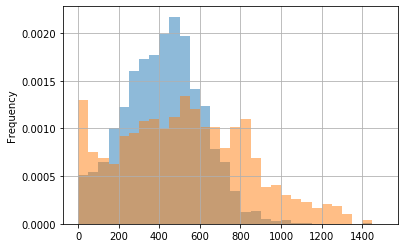

In [55]:
report.query('tariff == "smart"')['duration'].plot(kind='hist', bins=30, range=(0,1500), grid=True, density=True, alpha=0.5)
report.query('tariff == "ultra"')['duration'].plot(kind='hist', bins=30, range=(0,1500), grid=True, density=True, alpha=0.5)

Распределение продождительности звонков у клиентов тарифа Смарт нормальное. Наглядно видно, что дисперсия и стандартное отклонениу тарифа Ультра больше, чем у Смарта, больше выбросов. Средняя продожительность звонков по тарифу Смарт примерно 417, эта цифра близка к пакету минут в рамках их тарифа. Возможно, их поведение обсуловлено выбором тарифа. У тарифа Ультра в пакете 3000 минут, возможно, их средняя продожительность приближена больше к реальным потребностям человека. Однако в колонке выручки по тарифу Смарт мы видим, что клиенты часто выходят за рамки абонентской платы.

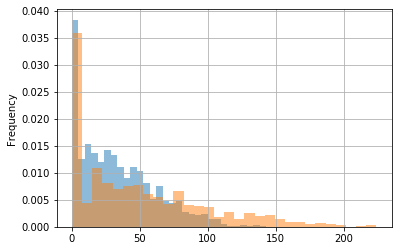

In [56]:
report.query('tariff == "smart"')['messages'].plot(kind='hist', bins=30, grid=True, density=True, alpha=0.5)
report.query('tariff == "ultra"')['messages'].plot(kind='hist', bins=30, grid=True, density=True, alpha=0.5)

Отправка сообщений не пользуется большим спросом. Однако среднее количество сообщений клиентов тарифа Ультра выше. 

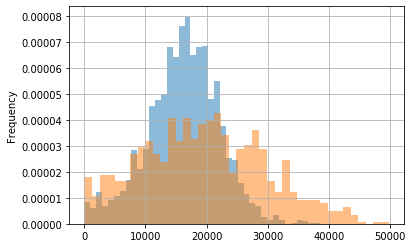

In [57]:
report.query('tariff == "smart"')['mb_used'].plot(kind='hist', bins=40, grid=True, density=True, alpha=0.5)
report.query('tariff == "ultra"')['mb_used'].plot(kind='hist', bins=40, grid=True, density=True, alpha=0.5)

Распределение тарифа Смарт нормальное. Стандартное отклонение и дисперсия меньше, чем у клиентов тарифа Ультра. В среднем клиента тарифа Смарт тратят 16 Гб интернет-трафика, что превышает количество трафика в пакете тарифа. Среднее потраченное количество трафика клиентов Ультра равно 19 Гб, что находится в рамках тарифа. Ситуация похожая со звонками, но касательно интернета, можно сделать вывод, что клиенты Смарта, скорее всего докупают интернет-трафик. 

Обобщив данные, можно сделать выводы: 

- Клиенты тарифа СМАРТ докупают в течение месяца услуги, так как им не хватает пакетов в рамках тарифа 
- Клиенты тарифа Ультра полностью укладываются в свои лимиты 
- Данные тарифа СМАРТ , в том числе среднее по продолжительности звонков, количеству сообщений и интернет-трафику, а также стандартное отклонение и дисперсия превышает цифры по тарифу УЛЬТРА.

В рамках проекта нам предложены две гипотезы. 
1) Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2) Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нам дана нулевая гипотеза, пропишем альтернативную. Нам надо проверить гипотезу о равенстве двух генеральных совокупностей. 
- H₀ - Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны
- H₁ - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [58]:
smart_re = smart['revenue']
ultra_re = ultra['revenue']

alpha = .05 

results = st.ttest_ind(
    smart_re, 
    ultra_re, 
    equal_var=False) # дисперсии не равны 

print('p-значение:', results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6266511203134947e-298
Отвергаем нулевую гипотезу


По средним данным выручки с тарифов, мы можем видеть в какую сторону сработала гипотеза. Выручки не равны, а выручка от тарифа Ультра намного больше выручки с тарифа Смарт.

Вторая гипотеза и альтернативная ней:

- H₀ - Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов
- H₁ - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов


In [59]:
moscow = report[(report['city'] == 'Москва')] # выбираем город Москва


In [60]:
regions = report[(report['city'] != 'Москва')]
regions

,user_id,month,total_calls,duration,mb_used,messages,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,5,22.0,159.0,2253.49,22.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
1,1000,6,43.0,172.0,23233.77,60.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
2,1000,7,47.0,340.0,14003.64,75.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
3,1000,8,52.0,408.0,14055.93,81.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
4,1000,9,58.0,466.0,14568.91,57.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,11050.56,17.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,smart,550.00
3210,1489,9,0.0,0.0,17206.30,32.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,smart,910.61
3211,1489,10,0.0,0.0,19559.44,21.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,smart,1370.20
3212,1489,11,0.0,0.0,17491.56,20.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,smart,966.32


In [61]:
moscow_re = moscow['revenue']
regions_re = regions['revenue']

alpha = 0.05

results = st.ttest_ind(
    moscow_re, 
    regions_re) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.4698451945226827
Не получилось отвергнуть нулевую гипотезу


Исходя из данных по средней выручке Москвы и регионов, не получилось отвергнуть нулевую гипотезу. Средняя выручка пользователей из Москвы практически равна выручке пользователей из других регионов. 

Проведя анализ двух тарифов, мы можем сделать следующие выводы: 

- Клиенты тарифа SMART часто выходят за рамки пакетов своего тарифа и покупают дополнительные минуты и интернет-трафик. средняя выручка по тарифу выше базовой стоимости практически в два раза. 
- Клиенты тарифа ULTRA в подавляющем большинстве случаев не превышают лимиты своего тарифа. 
- Cредняя выручка с тарифа ULTRA выше выручки с тарифа SMART
- Средняя выручка по Москве не отличается от выручки других регионов 

Можно предположить, что клиенты, которым не хватает пакетов в рамках SMART перейдут со временем на ULTRA. На данный момент выручка больше у тарифа ULTRA. Проанализировав поведение клиентов, мы увидели, что на ULTRA практически никогда не выхождят за рамки пакетов, возможно, стоит изменить условия тарифа на "Безлимит", что привлечет внимание и привлечет внимание клиентов без убытков по тарифу. 